In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "None"
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"

In [2]:
import jax.numpy as jnp
from jax import random, vmap

import numpy as onp

import matplotlib.pyplot as plt
import pickle

In [3]:
from ground_truth import gt_op
from sequential import get_initial_dataset
from sequential import true_s

import sys
sys.path.append('..') # makes modules in parent repository available to import

from acquisition import MCAcquisition

I0000 00:00:1711480989.944115  109081 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.
2024-03-26 15:23:09.995923: E external/xla/xla/stream_executor/cuda/cuda_driver.cc:276] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)
2024-03-26 15:23:12.053748: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Testing data shapes
u: (512, 4)
y: (512, 12, 2)
s: (512, 12)
w: (512, 1)


In [4]:
N = 5 # number of initial examples
dim_u = 4 # grid definition of intput functions
dim_s = 12 # grid definition of output functions
lb = jnp.array([7.0, 0.02, 0.01, 30.01]) # lower bounds
ub = jnp.array([13.0, 0.12, 3.0, 30.295]) # upper bounds

s1 = jnp.array([0.0, 1.0, 2.5]) # positions
t1 = jnp.array([15.0, 30.0, 45.0, 60.0]) # times
T, X = jnp.meshgrid(t1, s1) # shapes (3,4) and (3,4)
y0 = jnp.hstack([T.flatten()[:,None], X.flatten()[:,None]]) # shape (12,2)

In [5]:
posterior = lambda x : x

acq_model = MCAcquisition(posterior, (lb, ub),
                        acq_fn = 'random_unif')

In [6]:
acq_model.next_best_point(q=1)

Array([12.443878  ,  0.06676089,  0.4644468 , 30.157583  ], dtype=float32)

In [11]:
def get_dataset(seed, num_init=5, num_new=30, q=1):
    # initializes training dataset
    num_init = 5 # number of initial examples
    dataset = get_initial_dataset(random.PRNGKey(seed), num_init, verbose=False)
    u_train, y_train, s_train, w_train = dataset
    for _ in range(num_new):
        new_coeffs = acq_model.next_best_point(q=1).reshape(q,-1)
        u_new = new_coeffs # (q, dim_u)
        y_new = jnp.tile(y0, (q, 1, 1)) # (q, dim_s, P)
        s_new = jnp.array([gt_op(u) for u in new_coeffs])[:,:,0] # (q, dim_s)
        w_new = 1/jnp.linalg.norm(s_new, axis=(-1))[:,None]**2 # (q,1)

        # augumenting dataset
        u_train = jnp.concatenate([u_train, u_new], axis=0) # shape (N+q, dim_u)
        y_train = jnp.concatenate([y_train, y_new], axis=0) # shape (N+q, dim_s, P)
        s_train = jnp.concatenate([s_train, s_new], axis=0) # shape (N+q, dim_s)
        w_train = jnp.concatenate([w_train, w_new], axis=0) # shape (N+q, 1)
    return (u_train, y_train, s_train, w_train)

In [12]:
objective = lambda s : ((s-true_s)**2).mean()

In [13]:
obj_hist = []

In [14]:
folder_name = 'collected_datasets/'
for seed in [0,1,2,3,4,5,6,7,8,9]:
    # Collect dataset
    dataset = get_dataset(seed)

    # Save dataset
    file_name = f'dataset_30_random_unif_seed{seed}.npz'
    with open(folder_name+file_name, 'wb') as f:
        pickle.dump(dataset, f)
    
    # Compute objectives
    obj_hist.append(vmap(objective)(dataset[2]))
    print(f"Done with seed {seed}")

Done with seed 0
Done with seed 1
Done with seed 2
Done with seed 3
Done with seed 4
Done with seed 5
Done with seed 6
Done with seed 7
Done with seed 8
Done with seed 9


In [15]:
[v.min() for v in obj_hist]

[Array(1.5641427, dtype=float32),
 Array(1.5882841, dtype=float32),
 Array(1.4815421, dtype=float32),
 Array(1.635569, dtype=float32),
 Array(1.5539165, dtype=float32),
 Array(1.5111867, dtype=float32),
 Array(1.5402437, dtype=float32),
 Array(1.5270206, dtype=float32),
 Array(1.5499068, dtype=float32),
 Array(1.6523205, dtype=float32)]

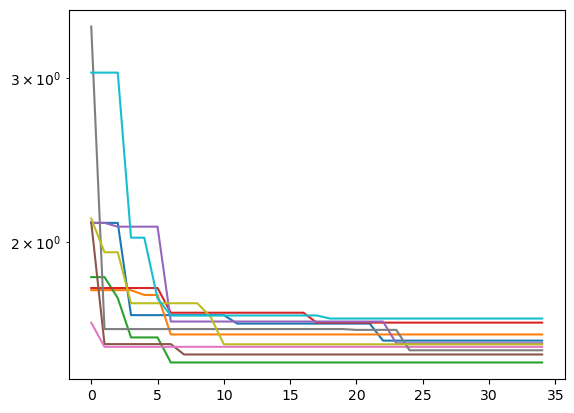

In [16]:
for obj in obj_hist:
    plt.plot(onp.minimum.accumulate(obj))
plt.yscale('log')
plt.show()

In [17]:
regrets = [onp.minimum.accumulate(obj) for obj in obj_hist]

In [18]:
with open('random_unif_regrets.npz', 'wb') as f:
    pickle.dump(regrets, f)

In [19]:
rs = pickle.load(open('random_unif_regrets.npz', "rb"))

In [20]:
type(rs)

list

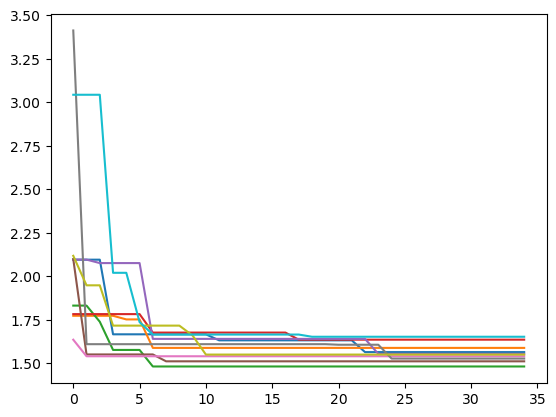

In [21]:
for r in rs:
    plt.plot(r)

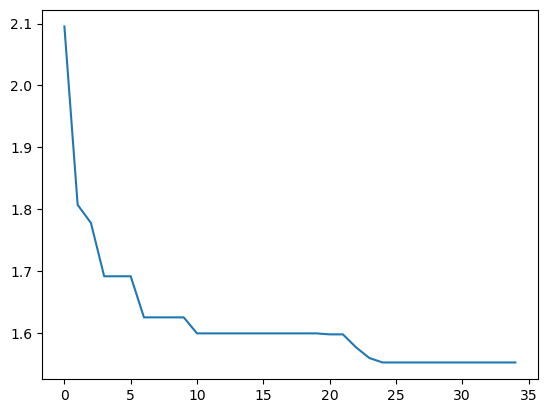

In [22]:
m = onp.median(onp.array(rs), axis=0)
plt.plot(m)